# Prueba 1: Análisis de Sentimientos de Twitter

<br>
<div class="alert alert-block alert-success">
<b>Nombre del Grupo:</b> Tusca.

<b>Integrante 1:</b> Juan Jose Uribe Mella.

<b>Integrante 2:</b> Nicolás Ignacio Gómez Espejo.

<b>Integrante 3:</b> Rafael Ignacio Mascayano O'Ryan.

<b>Integrante 4:</b> Javier Ignacio López Sanhueza.

               

<b>Generación:</b> Generación 2.

<b>Profesor:</b> Gabriel Tamayo L.

</div>


A  continuación  se  presenta un  problema clásico en  el  análisis de  texto: Extraer el  sentimiento asociado a un texto. Para esto, utilizaremos una base de datos provenientes de CrowdFlower. Para descargar los datos puede ejecutar el siguiente código: 

`wget https://www.crowdflower.com/wp-content/uploads/2016/07/text_emotion.csv`

El objetivo general de esta prueba es alcanzar el mejor desempeño posible para clasificar si un tweet es positivo o negativo. Para medir el desempeño, se evaluará con un conjunto de datos del cuál no tendrán acceso. De esta manera evitaremos que los modelos aprendan información sobre el conjunto de validación.

## Requerimientos

Realizaremos un análisis de sentimientos de un Tweet para saber si este está asociado a un sentimiento positivo o a un sentimiento negativo.

![Example](tweet-example.png)

Para esto utilizaremos la base de datos provenientes de _CrowdFlower_.

## Vector Objetivo

El vector objetivo será una variable binaria que indicará si el sentimiento es positivo o no.

## Métricas a utilizar

Como este es un problema de clasificación, nos centraremos en la predicción de la clasificación para una nueva observación. Para lo cual se utilizarán las siguientes métricas:

- **Matrix de confusión**: cantidad de observaciones predichas de forma correcta.
- **Accuracy** (exactitud): porcentaje de casos predichos correctamente por sobre el total de casos.
- **Precision**: mide la fracción de predicciones correctas entre las etiquetas positivas.
- **Recall**: Mide la fraccion de verdaderos positivos predichos por el modelo.
- **F1**: representa la media armónica entre Precision y Recall (es decir, una medida general de la presición).
- **ROC** (en particular, _AUC_): evalúa la relación entre ambos errores (falsos positivos y falso negativo) condicional en todo el rango del clasificador.

De la misma forma se usarán modelos de clasificación entre los que destaca:
- Regresión Logística,
- Máquina de Soporte Vectorial,
- Naive Bernoulli,
- Random Forest,
- Ridge,
- AdaBoost,
- Redes Neuronales,


## Análisis Exploratorio

Se procede a evaluar las variables y explorar de forma grafica el comportamientos de aquellas. Previo a aquello se procede a cargar las librerias necesarias y básicas de un data scientist.

In [1]:
# Importar librerías básicas
import warnings
warnings.filterwarnings('ignore')

# Importación de librerías clásicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import missingno as msgo

# Importación de librerías de ML
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer

# Importación de librerías para el tratamiento de texto
import nltk
nltk.download('stopwords', quiet=True)

# Importación de librería para la persistencia del modelo  
import pickle

# Import helpers
import helpers as nicos

sns.set_style("darkgrid")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
content      30000 non-null object
sentiment    30000 non-null object
dtypes: object(2)
memory usage: 468.8+ KB


,content,sentiment
0,Happy Mama's day to all mothers,love
1,@LysdelTellez I am lost. Please help me find a...,worry
2,"@BoomKatt yes yes I AM, networking whore to th...",happiness
3,you@snapplynn Wish that would have been your t...,neutral
4,now i am doing the MicroEconomics project iha...,worry


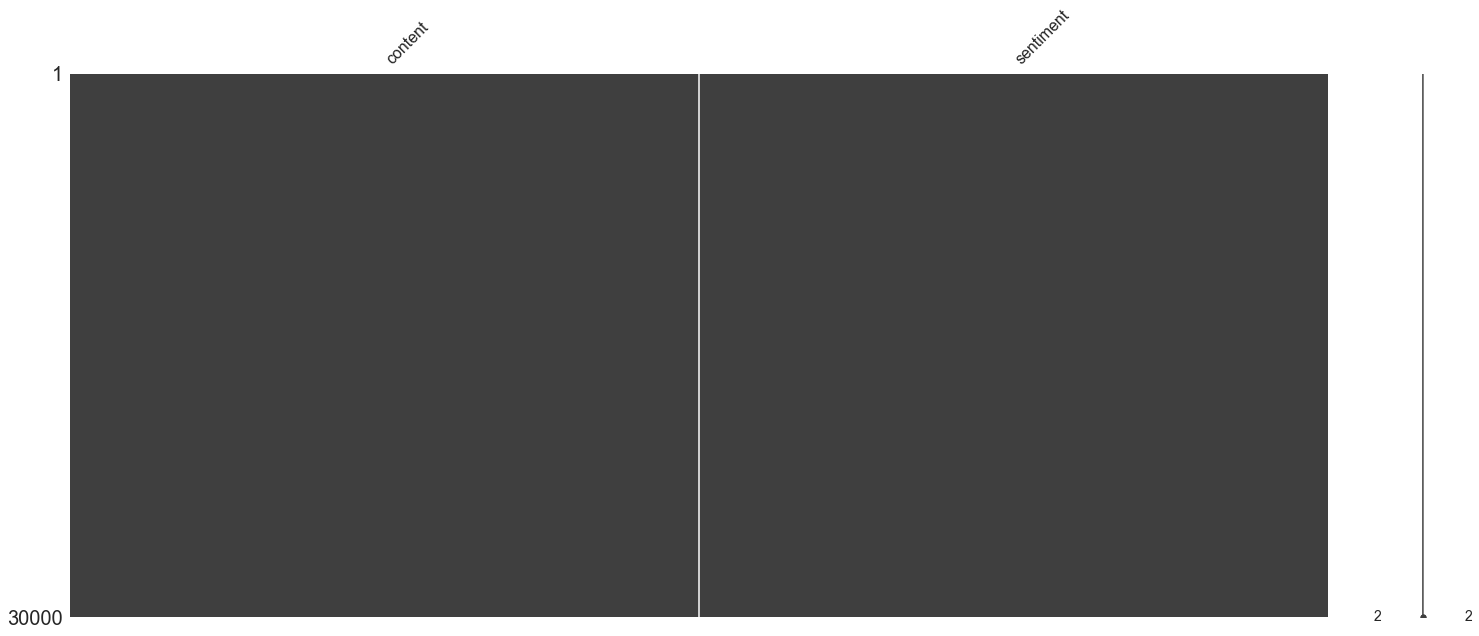

In [2]:
# Se carga el la base de datos entregada en la web Desafio Latam. 
# Se observa que es necesario eliminar la columna con "Unnamed: 0", debido a que no entrega información

df = pd.read_csv('training_tweets.csv').drop('Unnamed: 0', axis=1)

# Se evalua el contenido y el tipo de dato en su interior. De forma paralela se busca la existencia de NaN.
df.info()

msgo.matrix(df)

df.head()

Notar que el dataset no contiene valores NaN. 

### Vector Objetivo

Veamos como distribuye el vector objetivo sin preprocesar:

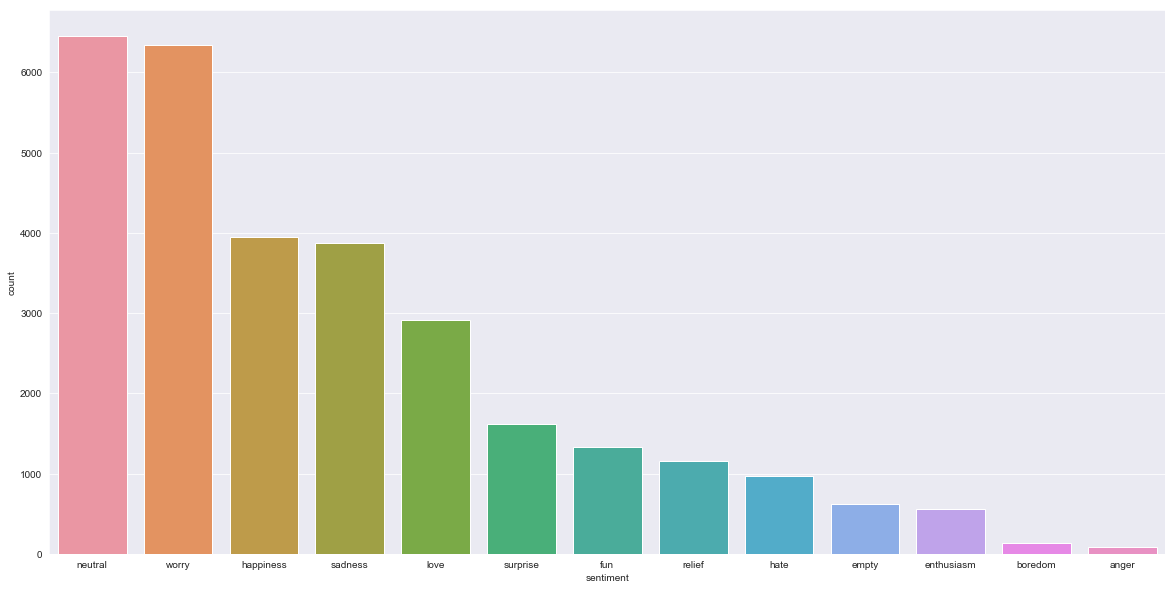

In [3]:
plt.figure(figsize=(20, 10))
sns.countplot(df.sentiment, order=df.sentiment.value_counts().index);

Notar que hay muchos datos neutrales. Para no afectar el resultado, en la etapa de _feature engineering_ vamos a eliminar los registros neutrales.

### Atributos

El único atributo es `content` el cual es el texto con el Tweet. A continuación veremos cuales son las palabras más repetidas considerando todas las observaciones no neutrales:

In [4]:
nicos.most_common_words(df[df.sentiment != 'neutral'].content.str.lower())[:10]

,freq
day,2082
just,1933
good,1474
like,1183
love,1145
quot,1103
today,1049
happy,1049
got,1026
http,985


Las palabras asociadas a sentimientos positivos:

In [5]:
nicos.most_common_words(df[df.sentiment.isin(['happiness', 'love', 'surprise', 'fun', 'relief', 'enthusiasm'])].content.str.lower())[:10]

,freq
day,1417
good,975
just,964
love,933
happy,891
quot,673
http,612
lol,598
like,536
thanks,523


Las palabras asociadas a sentimientos negativos:

In [6]:
nicos.most_common_words(df[~df.sentiment.isin(['happiness', 'love', 'surprise', 'fun', 'relief', 'enthusiasm'])].content.str.lower())[:10]

,freq
just,1405
day,986
work,911
like,908
http,786
today,780
got,767
good,761
going,744
quot,726


## Preprocesamiento y Feature Engineering

### Estrategia de Preprocesamiento

Se propone realizar un preprocesamiento de los datos, por medio de lo sugerido en el enunciado con Lemantización. Para esto se debe estudiar las funciones de la librería NTLK. De la misma forma, se puede proceder a separar las palabras de los comentarios con CountVectorizer o con TfidVectorizer. 
Luego de este preprocesamiento, se aplicaran los modelos, evaluando cual de ellos es el mejor, de las misma forma se planea utilziar un modelo de votación de ensamble para evaluar los mejores. De esta forma, se utilizarán los modelos con ambos preprocesamientos, y se eligirá el mejor modelo en tiempo de procesamiento y resultados.


In [7]:
# Primero filtramos sentimientos que no son neutrales
df = df[df.sentiment != 'neutral']

### Vector Objetivo

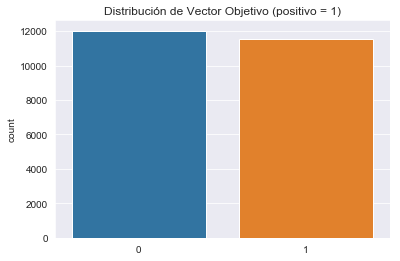

In [8]:
# Ahora generamos el vector objetivo binarizado
positive_elements = ['happiness', 'love', 'surprise', 'fun', 'relief', 'enthusiasm']
y = np.where(np.isin(df.sentiment, positive_elements), 1, 0)

sns.countplot(y);
plt.title('Distribución de Vector Objetivo (positivo = 1)');

Ambas clases están balanceadas:

In [9]:
pd.Series(y).value_counts()

0    12022
1    11527
dtype: int64

### Atributos

Aplicaremos lemantización y tokenización sobre los Tweets.

Guardamos en `X` la matriz de atributos (para este ejercicio, es sólo 1 columna):

In [10]:
X = df.content

Para el preprocesamiento, utilizaremos las stopwords del diccionario inglés junto a otros signos que no aportan información en la clasificación:

In [11]:
stopwords = nltk.corpus.stopwords.words("english") + ['!','.','@',',','...','?','s', '&','/',';','-','..','"', '½']
stopwords = set(stopwords)
tokenizer = nicos.LemmaTokenizer()
tokenized_stopwords = tokenizer(' '.join(stopwords))

Crearemos un objeto con `CountVectorizer` para utilizarlo en los modelos:

In [12]:
count_vectorizer = CountVectorizer(tokenizer=nicos.LemmaTokenizer(),
                                   strip_accents = 'unicode',
                                   stop_words = tokenized_stopwords,
                                   max_features= 2000,
                                   lowercase = True)

count_model_fit = count_vectorizer.fit_transform(X)

Las siguientes son las 10 palabras más repetidas:

In [13]:
most_common = pd.DataFrame(count_model_fit.toarray(), columns = count_vectorizer.get_feature_names())
most_common = most_common.sum().sort_values(ascending=False)
most_common[:10]

day      2366
i'm      2083
good     1469
get      1312
love     1213
like     1206
go       1152
today    1047
happy    1046
got      1027
dtype: int64

## Implementación de modelos

In [14]:
x_train, x_test, y_train, y_test, = train_test_split(X, y, test_size = 0.33, random_state = 4092019)

#### Primer Modelo: NaiveBernoulli

In [15]:
model_pip_bernoulli = Pipeline([('countV', count_vectorizer),('NB',BernoulliNB())])
model_pip_bernoulli.fit(x_train, y_train)
print(classification_report(y_test,model_pip_bernoulli.predict(x_test)))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74      3959
           1       0.74      0.70      0.72      3813

    accuracy                           0.73      7772
   macro avg       0.73      0.73      0.73      7772
weighted avg       0.73      0.73      0.73      7772



#### Segundo Modelo: Regresión Logística

In [15]:
model_pip_LR = Pipeline([('countV', count_vectorizer),('Lg', LogisticRegression(random_state=4092019))])
model_pip_LR.fit(x_train, y_train)
print(classification_report(y_test,model_pip_LR.predict(x_test)))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73      3959
           1       0.72      0.70      0.71      3813

    accuracy                           0.72      7772
   macro avg       0.72      0.72      0.72      7772
weighted avg       0.72      0.72      0.72      7772



In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

tfid = TfidfVectorizer(tokenizer=nltk.tokenize.TweetTokenizer().tokenize,
                                   strip_accents = 'unicode',
                                   stop_words = nltk.tokenize.TweetTokenizer().tokenize(' '.join(stopwords)),
                                   lowercase = True)

model_pip_LR = Pipeline([('countV', tfid),('Lg', LogisticRegression(random_state=4092019))])
model_pip_LR.fit(x_train, y_train)

print(classification_report(y_test,model_pip_LR.predict(x_test)))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75      3959
           1       0.74      0.70      0.72      3813

    accuracy                           0.73      7772
   macro avg       0.73      0.73      0.73      7772
weighted avg       0.73      0.73      0.73      7772



#### Tercer Modelo: Máquina de Soporte Vectorial

In [18]:
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma = [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

parameters_first = {
    "kernel":["rbf"],
    "C": C[:3],
    "gamma": gamma[:3]
}

parameters_second = {
    "kernel": ["rbf"],
    "C": C[3:],
    "gamma": gamma[3:],
}

parameters_third = {
    "kernel": ["rbf"],
    "C": C[:3],
    "gamma": gamma[3:]
}

parameters_fourth = {
    "kernel": ["rbf"],
    "C": C[3:],
    "gamma": gamma[:3]
}

def get_gs_svm(params):
    return Pipeline([
        ('countV', count_vectorizer),
        ('grid', GridSearchCV(SVC(random_state=4092019, probability=True), param_grid=params, cv=2, n_jobs=-1, refit=True)),
    ])

In [19]:
# Dado el tiempo de ejecución se separa en dos modelos
model_GS_SVM_first = get_gs_svm(parameters_first)
model_GS_SVM_first.fit(x_train, y_train)
print(classification_report(y_test, model_GS_SVM_first.predict(x_test)))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67      3959
           1       0.00      0.00      0.00      3813

    accuracy                           0.51      7772
   macro avg       0.25      0.50      0.34      7772
weighted avg       0.26      0.51      0.34      7772



In [20]:
# Segundo modelo de SVM con segundo grupo de hiperparámetros
model_GS_SVM_second = get_gs_svm(parameters_second)
model_GS_SVM_second.fit(x_train, y_train)
print(classification_report(y_test, model_GS_SVM_second.predict(x_test)))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      3959
           1       0.75      0.67      0.71      3813

    accuracy                           0.73      7772
   macro avg       0.73      0.73      0.73      7772
weighted avg       0.73      0.73      0.73      7772



In [21]:
# Tercer modelo de SVM con tercer grupo de hiperparámetros
model_SVC_third = get_gs_svm(parameters_third)
model_SVC_third.fit(x_train, y_train)
print(classification_report(y_test, model_SVC_third.predict(x_test)))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67      3959
           1       0.00      0.00      0.00      3813

    accuracy                           0.51      7772
   macro avg       0.25      0.50      0.34      7772
weighted avg       0.26      0.51      0.34      7772



In [22]:
# Cuarto modelo de SVM con tercer grupo de hiperparámetros
model_SVC_fourth = get_gs_svm(parameters_fourth)
model_SVC_fourth.fit(x_train, y_train)
print(classification_report(y_test,model_SVC_fourth.predict(x_test)))

              precision    recall  f1-score   support

           0       0.72      0.77      0.74      3959
           1       0.74      0.68      0.71      3813

    accuracy                           0.73      7772
   macro avg       0.73      0.73      0.73      7772
weighted avg       0.73      0.73      0.73      7772



#### Cuarto Modelo: Random Forest

In [23]:
parameters = {
    "n_estimators": list(np.linspace(20, 1000, 50, dtype = "int")),
    "max_features": [None, "log2", "sqrt"]
}

rfc = RandomForestClassifier(
    oob_score = True,
    criterion = "gini",
    max_depth = 16,
    random_state = 4092019
)

model_GS_rf = Pipeline([('countV', count_vectorizer),
                         ('grid', GridSearchCV(rfc, param_grid = parameters, cv = 2, n_jobs=-1))])

model_GS_rf.fit(x_train, y_train)

print(classification_report(y_test, model_GS_rf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.65      0.85      0.74      3959
           1       0.77      0.52      0.62      3813

    accuracy                           0.69      7772
   macro avg       0.71      0.69      0.68      7772
weighted avg       0.71      0.69      0.68      7772



#### Quinto Modelo: Ridge

In [24]:
parameters = {
    'alpha': [1e-3, 1e-2, 1e-1, 1],
    'normalize': [True, False],
}

model_GS_ridge = Pipeline([
    ('countV', count_vectorizer),
    ('grid', GridSearchCV(RidgeClassifier(random_state=4092019), param_grid=parameters, cv = 2, n_jobs=-1))
])

model_GS_ridge.fit(x_train, y_train)
print(classification_report(y_test, model_GS_ridge.predict(x_test)))

              precision    recall  f1-score   support

           0       0.74      0.71      0.72      3959
           1       0.71      0.73      0.72      3813

    accuracy                           0.72      7772
   macro avg       0.72      0.72      0.72      7772
weighted avg       0.72      0.72      0.72      7772



## Elección de modelo

Para tener más información sobre cual modelo elegir, calcularemos el AUC score y además las curvas ROC de cada modelo:

In [25]:
roc_curves = {}

models = [
    ('bernoulli', model_pip_bernoulli),
    ('LR', model_pip_LR),
    ('SVM', model_GS_SVM_second),
    ('RF', model_GS_rf),
    ('Ridge', model_GS_ridge),
]

for i, (name, model) in enumerate(models):
    if name == 'Ridge': # https://stackoverflow.com/a/22587041
        d = model.decision_function(x_test)
        prob = np.exp(d) / np.sum(np.exp(d))
    else:
        prob = model.predict_proba(x_test)[:, 1]
    roc_curves[i] = roc_curve(y_test, prob)
    print(name, 'AUC:', roc_auc_score(y_test, prob))

bernoulli AUC: 0.7967033851501892
LR AUC: 0.8066507760140708
SVM AUC: 0.80364229682597
RF AUC: 0.7875176698055144
Ridge AUC: 0.7910741870498337


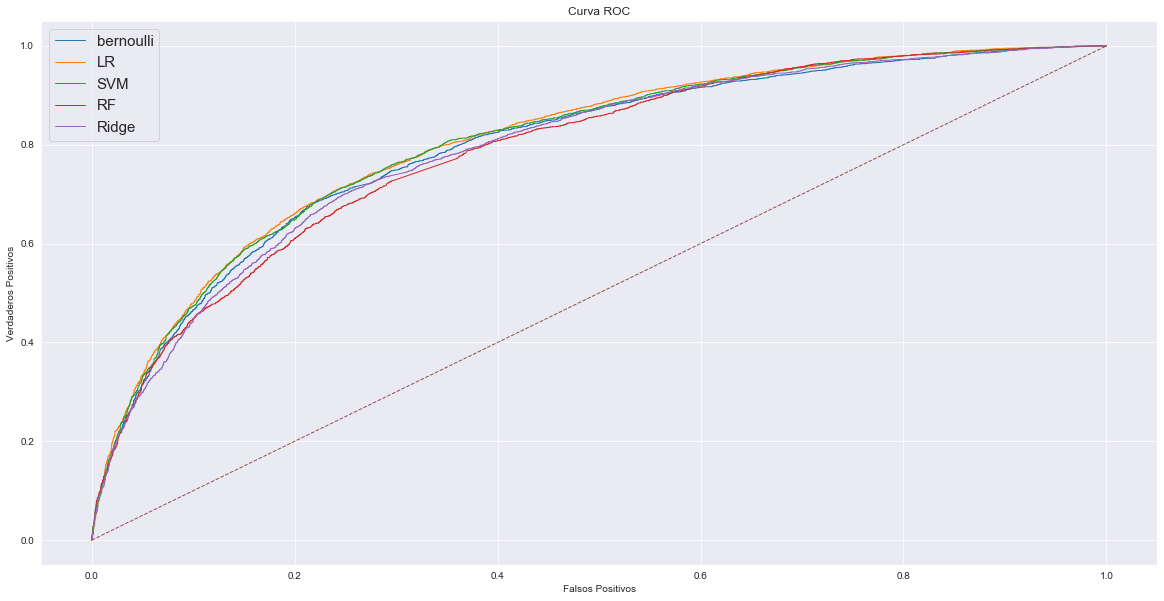

In [26]:

plt.figure(figsize=(20, 10))

plt.title('Curva ROC')


for i, (name, model) in enumerate(models):
    plt.plot(roc_curves[i][0], roc_curves[i][1], lw=1, label=name)

plt.plot([0, 1], ls="--", lw=1)
plt.ylabel('Verdaderos Positivos')
plt.legend(prop={'size': 15})
plt.xlabel('Falsos Positivos');

Los puntajes AUC son parecidos, siendo el mayor el modelo de regresión.

Los modelos más estables en base a las métricas de `presicion`, `recall` y `f1-score` son LR y Ridge (estos tienen todas las métricas sobre 0.7). Debido a esto sumado a que LR tiene mejor AUC, nos quedaremos con el modelo de regresión:

In [17]:
pickle.dump(model_pip_LR, open("grupo_nicos_&_tuskas_model_pip_LR.sav","wb"))

### PD:

¿Y qué ocurre con el Tweet de la imagen al comienzo?

In [28]:
tweet = "Democrat Congresswoman totally fabricated what I said to the wife of a soldier who died in action (and I have proof). Sad!"

for i, (name, model) in enumerate(models):
    prediction = model.predict([tweet])[0]
    if prediction == 1:
        print(name, ':', '👍')
    else:
        print(name, ':', '😡')

bernoulli : 😡
LR : 😡
SVM : 😡
RF : 😡
Ridge : 😡


Tal y como era de esperar 😇